Once deleted, variables cannot be recovered. Proceed (y/[n])? y


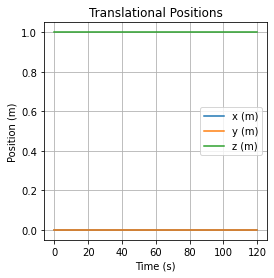

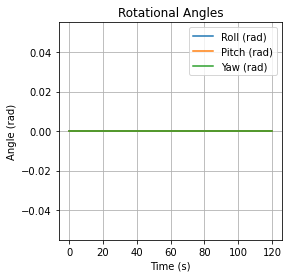

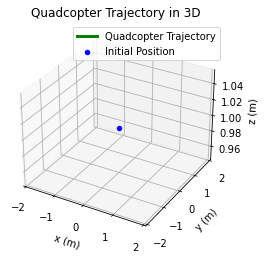

In [1]:
# Requirement 1: Hover for 2 minutes

%reset
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Moments of Inertia (kg m^2)
I_xx = 4.716e-4
I_yy = 4.716e-4
I_zz = 5.468e-3  

m = (33.6*4 + 123.5+3.79*4 + 197)/1000 # mass in kg
g = 9.81  # m/s²

k_t = 1.33e-6 # Lift coefficient
k_d = 1.9e-8 # Drag coefficient
d = 0.18   # Distance from drone center to rotor center


def torques(speed, k_t, k_d, d):
    T_total = k_t*(speed[0]**2 + speed[1]**2 + speed[2]**2 + speed[3]**2)
    tau_phi = d*k_t*(speed[3]**2 - speed[1]**2)
    tau_theta = d*k_t*(speed[0]**2 - speed[2]**2)
    tau_psi = d*k_d*(speed[0]**2 - speed[1]**2 + speed[2]**2 - speed[3]**2)
    return T_total, tau_phi, tau_theta, tau_psi
    
def dynamics(t, initial_conditions, speed):
    x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, omega1, omega2, omega3 = initial_conditions

    
    # Rotational matrix to convert from body frame of referenece to global referenece frame
    #R = np.array([[np.cos(psi)*np.cos(theta), np.sin(phi)*np.sin(theta)*np.cos(psi) - np.sin(psi)*np.cos(phi), np.cos(phi)*np.sin(theta)*np.cos(psi) + np.sin(psi)*np.sin(phi)],
                 #[np.sin(psi)*np.cos(theta), np.sin(phi)*np.sin(theta)*np.sin(psi) + np.cos(psi)*np.cos(phi), np.cos(phi)*np.sin(theta)*np.sin(psi) - np.sin(phi)*np.sin(psi)],
                 #[-np.sin(theta), np.cos(theta)*np.sin(phi), np.cos(phi)*np.cos(theta)]])
    
    R_phi = np.array([[1,0,0],
                    [0,np.cos(phi),-np.sin(phi)],
                    [0,np.sin(phi), np.cos(phi)]])

    R_theta = np.array([[np.cos(theta),0,np.sin(theta)],
                      [0,1,0],
                      [-np.sin(theta),0,np.cos(theta)]])

    R_psi = np.array([[np.cos(psi),-np.sin(psi),0],
                    [np.sin(psi),np.cos(psi),0],
                    [0,0,1]])

    R = R_psi @ R_theta @ R_phi
    

    T_total, tau_phi, tau_theta, tau_psi = torques(speed, k_t, k_d, d)
    
    x_ddot = (T_total/m)*(np.cos(phi)*np.sin(theta)*np.cos(psi) + np.sin(psi)*np.sin(phi))
    y_ddot = (T_total/m)*(np.cos(phi)*np.sin(theta)*np.sin(psi) - np.sin(phi)*np.cos(psi))
    z_ddot = -g + (T_total/m)*(np.cos(phi)*np.cos(theta))
    
    omega1_dot = (tau_phi - (I_zz - I_yy) * omega2 * omega3) / I_xx
    omega2_dot = (tau_theta - (I_xx - I_zz)*omega1*omega3)/I_yy
    omega3_dot = (tau_psi - (I_yy - I_xx*omega1*omega2))/I_zz
    
    euler_matrix = (1 / np.cos(theta))*np.array([
         [0, np.sin(psi) * np.tan(theta), np.cos(psi) * np.tan(theta)],
         [0, np.cos(psi)*np.cos(theta), -np.cos(theta)*np.sin(psi)],
         [np.cos(theta), np.sin(theta)*np.sin(psi), np.sin(theta)*np.cos(psi)],
    ])
    
    phi_dot, theta_dot, psi_dot = euler_matrix @ np.array([[omega1], [omega2], [omega3]])
    
    
    to_return = np.array([x_dot, y_dot, z_dot,
                         phi_dot, theta_dot, psi_dot,
                         x_ddot, y_ddot, z_ddot,
                         omega1_dot, omega2_dot, omega3_dot], dtype=object)
    return to_return

initial_conditions_hover = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

w = np.sqrt((m*g)/(4*k_t))
rotor_speed = np.array([w, w, w, w])

# Time range for simulation and plotting
t_span = (0, 120)
t_eval = np.linspace(*t_span, 1000) 

# Solving eqns
sol = solve_ivp(dynamics, t_span, initial_conditions_hover, args=(rotor_speed,), t_eval=t_eval,atol=1e-10, rtol=1e-10)

# Translational Positions
plt.figure(figsize=(4,4))
plt.plot(sol.t, sol.y[0], label='x (m)')
plt.plot(sol.t, sol.y[1], label='y (m)')
plt.plot(sol.t, sol.y[2], label='z (m)')
plt.title('Translational Positions')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.grid()
plt.legend()


# Rotational Angles
plt.figure(figsize=(4,4))
plt.plot(sol.t, sol.y[3], label='Roll (rad)')
plt.plot(sol.t, sol.y[4], label='Pitch (rad)')
plt.plot(sol.t, sol.y[5], label='Yaw (rad)')
plt.title('Rotational Angles')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.grid()
plt.legend()


# 3D Trajectory
fig_3D = plt.figure(figsize=(4,4))
ax = fig_3D.add_subplot(111, projection='3d')
ax.plot3D(sol.y[0], sol.y[1], sol.y[2], label='Quadcopter Trajectory', color='green', linewidth=3)
ax.scatter(sol.y[0][0], sol.y[1][0], sol.y[2][0], color='blue', s=20, label='Initial Position')
ax.set_title('Quadcopter Trajectory in 3D')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.grid()
ax.legend()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)


plt.show()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


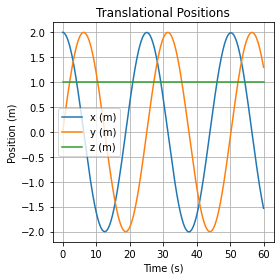

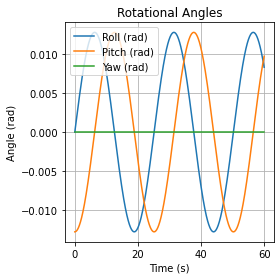

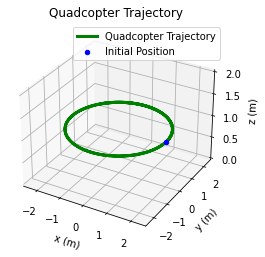

In [4]:
# Requirement 2: Fly in circle

%reset
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define constants
v = 0.5 #m/s
r = 2 # m
m = (33.6*4 + 123.5+3.79*4 + 197)/1000 # mass in kg
g = 9.81 #m/s^2

# Moments of Inertia (kg m^2)
I_xx = 4.716e-4
I_yy = 4.716e-4
I_zz = 5.468e-3  

k_t = 1.33e-6 # Lift coefficient
k_d = 1.9e-8 # Drag coefficient
d = 0.18 # Distance from drone center to rotor center

fc = m*v**2/r

phi_theta_max = np.arctan(fc/(m*g))
w_circle = v/r
w_h = np.sqrt((m*g)/(4*k_t))

def phi_t(t):
    return phi_theta_max*np.sin(w_circle*t)

def theta_t(t):
    return phi_theta_max*np.cos(w_circle*t)

# yaw is always 0 for this config

def rotor_speeds(t, w_h):
    phi = phi_t(t)
    theta = theta_t(t)
    omega1 = w_h*(1-phi-theta)
    omega2 = w_h*(1-phi+theta)
    omega3 = w_h*(1+phi+theta)
    omega4 = w_h*(1+phi-theta)
    return [omega1, omega2, omega3, omega4]

def ang_velo(t):
    a = phi_theta_max*w_circle*np.cos(w_circle*t)
    b = phi_theta_max*w_circle*np.sin(w_circle*t)
    c = 0
    return a, b, c


def torques(rotor_speeds,k,b,l):
    T =  k*(rotor_speeds[0]**2+rotor_speeds[1]**2+rotor_speeds[2]**2+rotor_speeds[3]**2)  # Total thrust
    tau_phi = l*k*(rotor_speeds[3]**2 - rotor_speeds[1]**2)  # Roll torque
    tau_theta = l*k*(rotor_speeds[2]**2 - rotor_speeds[0]**2)  # Pitch torque
    tau_psi = b*(rotor_speeds[0]**2 - rotor_speeds[1]**2 + rotor_speeds[2]**2 - rotor_speeds[3]**2)  # Yaw torque
    return T, tau_phi, tau_theta, tau_psi

def quadcopter_dynamics(t, state, rotor_speeds):

    x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, omega1, omega2, omega3 = state


    R_phi = np.array([[1,0,0],
                    [0,np.cos(phi),-np.sin(phi)],
                    [0,np.sin(phi), np.cos(phi)]])

    R_theta = np.array([[np.cos(theta),0,np.sin(theta)],
                      [0,1,0],
                      [-np.sin(theta),0,np.cos(theta)]])

    R_psi = np.array([[np.cos(psi),-np.sin(psi),0],
                    [np.sin(psi),np.cos(psi),0],
                    [0,0,1]])

    R = R_psi @ R_theta @ R_phi

    omega1, omega2, omega3 = ang_velo(t)

    rotor_speeds = rotor_speeds(t,w_h)

    T, tau_phi, tau_theta, tau_psi = torques(rotor_speeds,k_t,k_d,d)

    x_ddot = (T / m) * R[0, 2]
    y_ddot = (T / m) * R[1, 2]
    z_ddot = (T / m) * R[2, 2] - g

    omega1_dot = (tau_phi + (I_yy - I_zz) * omega2 * omega3) / I_xx
    omega2_dot = (tau_theta + (I_zz - I_xx) * omega3 * omega1) / I_yy
    omega3_dot = (tau_psi + (I_xx - I_yy) * omega1 * omega2) / I_zz

    B_inv = np.array([
        [1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)]])

    euler_rates = B_inv @ np.array([omega1, omega2, omega3])

    phi_dot, theta_dot, psi_dot = euler_rates
    
    to_return = np.array([x_dot, y_dot, z_dot,
                         phi_dot, theta_dot, 0,
                         x_ddot, y_ddot, 0,
                         omega1_dot, omega2_dot, omega3_dot], dtype=object)
    
    
    return to_return

initial_state = [2, 0, 1, 0, -phi_theta_max, 0, 0, .5, 0, ang_velo(0)[0], ang_velo(0)[1], ang_velo(0)[2]]

# Time range for simulation and plotting
t_span = (0, 60) 
t_eval = np.linspace(0, 60, 1000) 

# Solve eqns
solution = solve_ivp(quadcopter_dynamics, t_span, initial_state, args=(rotor_speeds,), t_eval=t_eval,atol=1e-10, rtol=1e-10)

# Translational Positions
plt.figure(figsize=(4,4))
plt.plot(solution.t, solution.y[0], label='x (m)')
plt.plot(solution.t, solution.y[1], label='y (m)')
plt.plot(solution.t, solution.y[2], label='z (m)')
plt.title('Translational Positions')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.tight_layout()

# Rotational Angles
plt.figure(figsize=(4,4))
plt.plot(solution.t, solution.y[3], label='Roll (rad)')
plt.plot(solution.t, solution.y[4], label='Pitch (rad)')
plt.plot(solution.t, solution.y[5], label='Yaw (rad)')
plt.title('Rotational Angles')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid()
plt.tight_layout()

# 3D Trajectory
fig_3D = plt.figure(figsize=(4,4))
ax = fig_3D.add_subplot(111, projection='3d')
ax.plot3D(solution.y[0], solution.y[1], solution.y[2], label='Quadcopter Trajectory', color='green', linewidth=3)
ax.scatter(solution.y[0][0], solution.y[1][0], solution.y[2][0], color='blue', s=20, label='Initial Position')
ax.set_title('Quadcopter Trajectory')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.legend()
ax.grid()
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(0, 2)

plt.show()